<a href="https://colab.research.google.com/github/maschu09/mless/blob/main/time_series_forecasting/3_AutoRegressive_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load the raw data for autoregressive models

In the previous notebook, we gained some insights on certain aspects of our data. In this notebook, we shall run the classical auto-regressive ARIMA model and see its performance.

In [24]:
import pandas as pd
import csv

## Raw data csv is also made available for the select stations in URL:
# url = "https://drive.google.com/uc?export=download&id=1cmTTWY3f18SikgRBcZzhtFswIf7XwPJq"
# dataframe = pd.read_csv(url,parse_dates=["datetime"])
variable_column = ["temp", "o3"]
# Else if using local files:
import os
TIMESERIES_DATA_DIR = "./timeseries_data/"
dataframe = pd.read_csv(os.path.join(TIMESERIES_DATA_DIR, "normalized_data.csv"))
dataframe.head()

,longitude,latitude,station_code,datetime,o3,temp
0,8.500619,50.567185,DEHE020,1992-03-12 05:00:00+00:00,-0.693768,-1.455491
1,8.500619,50.567185,DEHE020,1992-03-12 06:00:00+00:00,-0.451555,-1.455491
2,8.500619,50.567185,DEHE020,1992-03-12 07:00:00+00:00,-0.347749,-1.455491
3,8.500619,50.567185,DEHE020,1992-03-12 08:00:00+00:00,-0.987885,-1.455491
4,8.500619,50.567185,DEHE020,1992-03-12 09:00:00+00:00,-0.814875,-1.455491


In [25]:
dataframe.shape

(220312, 6)

In [26]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error

In [27]:
dataframe.head()

,longitude,latitude,station_code,datetime,o3,temp
0,8.500619,50.567185,DEHE020,1992-03-12 05:00:00+00:00,-0.693768,-1.455491
1,8.500619,50.567185,DEHE020,1992-03-12 06:00:00+00:00,-0.451555,-1.455491
2,8.500619,50.567185,DEHE020,1992-03-12 07:00:00+00:00,-0.347749,-1.455491
3,8.500619,50.567185,DEHE020,1992-03-12 08:00:00+00:00,-0.987885,-1.455491
4,8.500619,50.567185,DEHE020,1992-03-12 09:00:00+00:00,-0.814875,-1.455491


In [28]:
def create_sequences(data, variable_column, n_past=336, n_future=96):
    df = data.copy()
    df['datetime'] = pd.to_datetime(df['datetime'])
    df = df.sort_values(['station_code', 'datetime']).reset_index(drop=True)

    # 1) Encode station_code as integer codes (not as a categorical dtype!)
    df['sc_code'] = df['station_code'].astype('category')

    # 2) Boolean mask: True if exactly 1 hour after the previous row (per station)
    is1h = (
        df.groupby('station_code')['datetime']
          .diff()
          .eq(pd.Timedelta(hours=1))
    )

    # 3) Compute rolling count of consecutive 1h-gaps over (n_past + n_future - 1)
    gap_window = n_past + n_future - 1
    run = (
        is1h
        .groupby(df['station_code'])
        .rolling(window=gap_window, min_periods=gap_window)
        .sum()
        .reset_index(level=0, drop=True)
    )
    # # make sure it's integer (sum of Trues)
    # run = run.astype(int)

    # 4) 'ends' are indices where run >= gap_window (full contiguous block)
    ends = run[run >= gap_window].index

    # 5) Extract arrays
    sc_arr = df['sc_code'].values
    vals   = df[variable_column].values

    X_list, y_list = [], []
    for end_idx in ends:
        start_idx = end_idx - gap_window
        # ensure valid window and same station at both ends
        if start_idx >= 0 and sc_arr[start_idx] == sc_arr[end_idx]:
            block_sc  = sc_arr[start_idx : end_idx + 1]      # (gap_window+1,)
            block_var = vals[start_idx : end_idx + 1]        # (gap_window+1,)

            # stack station code + variable column
            block = np.column_stack((block_sc, block_var))

            X_list.append(block[:n_past, :])
            y_list.append(block[n_past:, :])

    if not X_list:
        return np.empty((0, n_past, 2)), np.empty((0, n_future, 2))

    X = np.stack(X_list)
    y = np.stack(y_list)
    return X, y

# Function to evaluate model performance
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    print(f"RMSE: {rmse:.4f}")
    return rmse

In [29]:
import pickle
context_window = 336
prediction_horizon = 96

X, y = create_sequences(dataframe,variable_column,context_window,prediction_horizon)

train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# with open("./content/X_train.pkl", "rb") as f:
#     X_train = pickle.load(f)

# with open("./content/X_test.pkl", "rb") as f:
#     X_test = pickle.load(f)

# with open("./content/y_train.pkl", "rb") as f:
#     y_train = pickle.load(f)

# with open("./content/y_test.pkl", "rb") as f:
#     y_test = pickle.load(f)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (69370, 336, 3), y_train shape: (69370, 96, 3)
X_test shape: (29730, 336, 3), y_test shape: (29730, 96, 3)


### Forecasting with MA models: SARIMAX


😈 **Task 1:** Try modeling without seasonal terms. How do AIC and RMSE compare?

😈 **Task 2:** Add an exogenous variable like `o3` into SARIMAX and observe results.

😈 **Question 1:** How does adding an exogenous variable enhance forecasting in SARIMAX?




ADF p-value: 0.01318843702336355


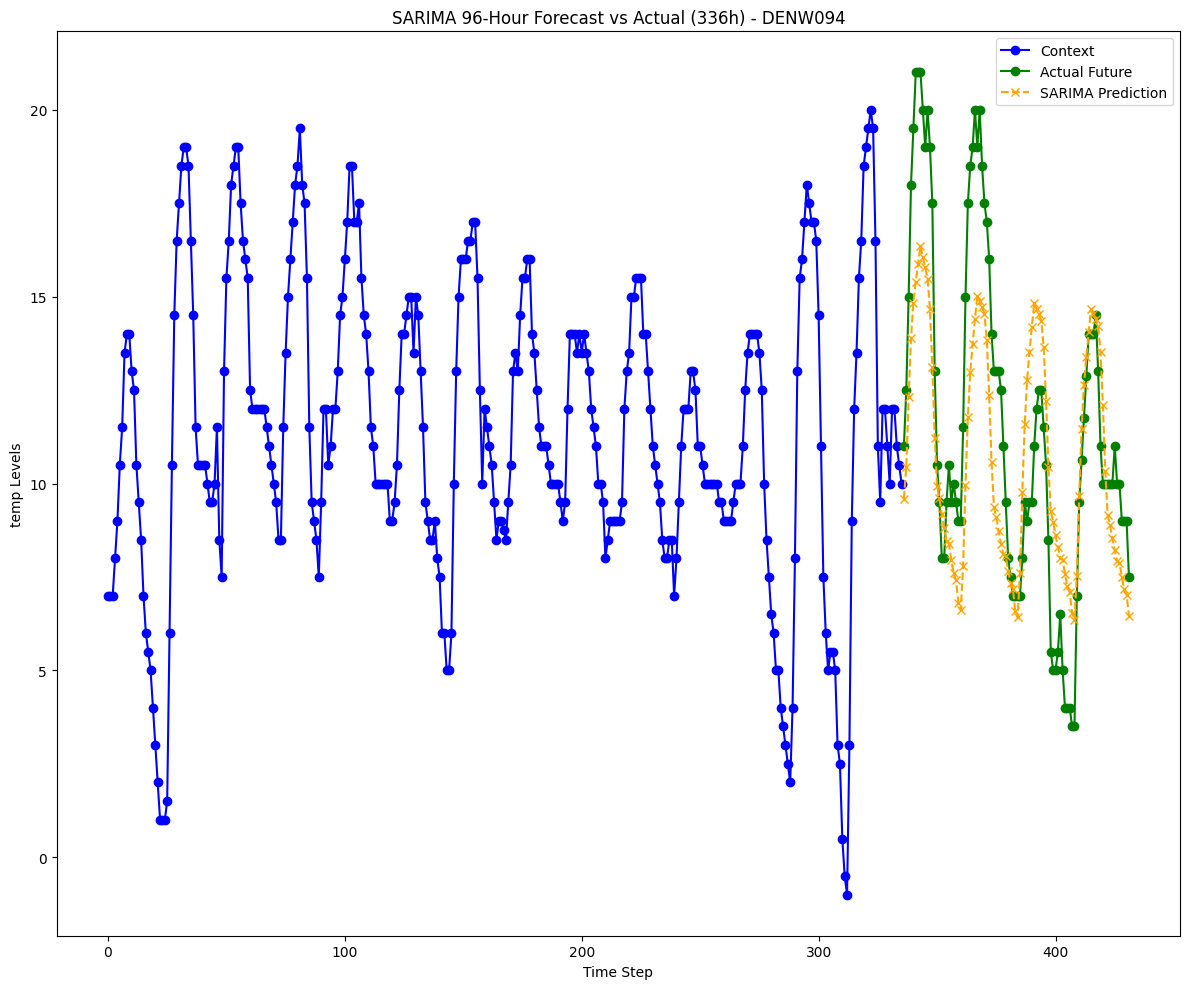

Mean Squared Error (MSE): 8.801


,SARIMA Summary
DENW094,SARIMAX R...


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error

# Define forecast horizon (96 hours = 4 days)
forecast_hours = 96

sarima_results = {}

# First sample of DENW094 station to compare with PatchTST
X_first_idx = np.flatnonzero(X_test[:, 0, 0] == 'DENW094')[0]
X_test_sample=X_test[X_first_idx, :, 1].astype(np.float32) # First column is station code hence adding 1
# First sample of DENW094 station to compare with PatchTST
y_first_idx = np.flatnonzero(X_test[:, 0, 0] == 'DENW094')[0]
y_test_sample=y_test[y_first_idx, :, 1].astype(np.float32) # First column is station code hence adding 1

# Check stationarity using ADF test
adf_test = adfuller(X_test_sample)
p_value = adf_test[1]
print(f"ADF p-value: {p_value}")

# Differencing if needed
d = 0 if p_value < 0.05 else 1  # If p-value < 0.05, it's stationary
seasonal_period = 24

# Fit SARIMA model
try:
    sarima_model = SARIMAX(X_test_sample,
        order=(1, d, 1),
        seasonal_order=(1, d, 1, seasonal_period),
        enforce_stationarity=False,
        enforce_invertibility=False).fit()

    fitted_values = sarima_model.fittedvalues
    forecast = sarima_model.get_forecast(steps=forecast_hours)
    forecast_values = forecast.predicted_mean
    confidence_intervals = forecast.conf_int()

    timesteps = np.arange(context_window, context_window + prediction_horizon)
    with open("denw094_temp_predictions_sarima.csv", "w", newline="") as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(["timestep", "temperature"])
        for t, pred in zip(timesteps, forecast_values):
            writer.writerow([t, pred])

    # Plot actual vs predicted values
    plt.figure(figsize=(12, 10))

    plt.plot(range(context_window),  X_test_sample, label="Context", color="blue", marker="o")
    plt.plot(range(context_window, context_window + prediction_horizon), y_test_sample, label="Actual Future", color="green", marker="o")
    plt.plot(range(context_window, context_window + prediction_horizon), forecast_values, label="SARIMA Prediction", linestyle="--", color="orange", marker="x")

    plt.title(f"SARIMA 96-Hour Forecast vs Actual (336h) - DENW094")
    plt.xlabel("Time Step")
    plt.ylabel("temp Levels")
    plt.legend()
    plt.tight_layout()
    plt.show()

    sarima_results["DENW094"] = sarima_model.summary()

    mse = mean_squared_error(y_test_sample, forecast_values)
    print(f"Mean Squared Error (MSE): {mse:.3f}")

except Exception as e:
    sarima_results['DENW094'] = f"Error: {e}"

sarima_results_df = pd.DataFrame.from_dict(sarima_results, orient='index', columns=['SARIMA Summary'])
display(sarima_results_df)


## Data Preprocessing (Normalization)

the snippet below uses standard Z normalization (this is a simple snippet alternatively other approaches could also be used as desired)


😈 **Task 3:** Implement min-max normalization and compare the results visually with Z-score.


In [7]:
import requests
import json
import pandas as pd
import os
import csv
from datetime import datetime

# German stations with good distribution temp variable observations
station_codes = ["DENW094", "DEBW073","DEHE020"]
variable_columns = ["temp"]
# station_codes = ["DENW094"]
# variable_columns = ["no2", "temp", "o3", "no", "press"]

In [8]:
def standard_scaler(df, columns):
    """
    Standardize the specified columns of a DataFrame by subtracting the mean
    and dividing by the standard deviation (Z-score normalization).

    Args:
        df (pd.DataFrame): The input DataFrame.
        columns (list): List of column names to be normalized.

    Returns:
        pd.DataFrame: DataFrame with normalized columns.
    """

    df_scaled = df.copy()
    for col in columns:
        df_scaled[col] = (
            df_scaled
            .groupby("station_code")[col]
            .transform(lambda x: (x - x.mean()) / x.std())
        )
    return df_scaled

In [9]:
dataframes = standard_scaler(dataframe, variable_columns)
dataframes.head()

,longitude,latitude,station_code,datetime,temp
0,7.567796,47.819182,DEBW073,1997-01-01 00:00:00+00:00,-2.564191
1,7.567796,47.819182,DEBW073,1997-01-01 01:00:00+00:00,-2.686422
2,7.567796,47.819182,DEBW073,1997-01-01 02:00:00+00:00,-2.686422
3,7.567796,47.819182,DEBW073,1997-01-01 03:00:00+00:00,-2.808654
4,7.567796,47.819182,DEBW073,1997-01-01 04:00:00+00:00,-2.808654


In [ ]:
TIMESERIES_DATA_DIR = "./content/timeseries_data/"
dataframes.to_csv(os.path.join(TIMESERIES_DATA_DIR, "normalized_data.csv"), index=False)
dataframes.shape

OSError: Cannot save file into a non-existent directory: 'content/timeseries_data'

: 

### Load the normalized data preparing samples for ML models.


> Samples are needed for sequence models and transformer models for input

😈 **Task 4:** What are some key differences between AR models and sequence models like RNNs or Transformers?

😈 **Question 2:** Why is it important to maintain time continuity when preparing samples for sequence models?



In [32]:
import pandas as pd
import os

## Normalized data csv is also made available for the select stations in URL:
# url = "https://drive.google.com/uc?export=download&id=1Eui59GyTXNv839WijdZ0CkzuMubmZQz1"
# dataframe = pd.read_csv(url,parse_dates=["datetime"])
# Else if using local files:
dataframes = pd.read_csv(os.path.join(TIMESERIES_DATA_DIR, "normalized_data.csv"))
variable_column = ["temp", "o3"]
dataframe.shape

(220312, 6)

80/20 train/test split chosen for illustration

😈 **Task 5:** Try a rolling-window cross-validation strategy. How does model performance vary?

😈 **Question 3:** What are the pitfalls of using random splits in timeseries forecasting?


In [33]:
context_window = 336
prediction_horizon = 96

X, y = create_sequences(dataframe,variable_column,context_window,prediction_horizon)

train_size = int(len(X) * 0.7)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (69370, 336, 3), y_train shape: (69370, 96, 3)
X_test shape: (29730, 336, 3), y_test shape: (29730, 96, 3)


In [35]:
import pickle

with open("./content/X_train.pkl", "wb") as f:
    pickle.dump(X_train, f)

with open("./content/X_test.pkl", "wb") as f:
    pickle.dump(X_test, f)

with open("./content/y_train.pkl", "wb") as f:
    pickle.dump(y_train, f)

with open("./content/y_test.pkl", "wb") as f:
    pickle.dump(y_test, f)

print("Train/test datasets saved successfully.")

Train/test datasets saved successfully.


In [ ]:
import pickle
## Processed data .pkl files are also made available for the select stations in URL
# Please download the files and place them in content subfolder
# else modify below path according to your chosen local download path:
# univariate case (temp) : https://drive.google.com/drive/folders/197WGFswCLYinkx-48XBMQKILwJQMokd0?usp=sharing

with open("./content/X_train.pkl", "rb") as f:
    X_train = pickle.load(f)

with open("./content/X_test.pkl", "rb") as f:
    X_test = pickle.load(f)

with open("./content/y_train.pkl", "rb") as f:
    y_train = pickle.load(f)

with open("./content/y_test.pkl", "rb") as f:
    y_test = pickle.load(f)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")


X_train shape: (373938, 336, 2), y_train shape: (373938, 96, 2)
X_test shape: (160260, 336, 2), y_test shape: (160260, 96, 2)
